# Statistics and Transformation using DataFrames

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

## Loading libraries

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

## Setting up Spark

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

## Loading Data

In [4]:
# delete files from previous runs
!rm -f hmp.parquet*

# download the file containing the data in PARQUET format
!wget https://github.com/IBM/coursera/raw/master/hmp.parquet
    
# create a dataframe out of it
df = spark.read.parquet('hmp.parquet')

# register a corresponding query table
df.createOrReplaceTempView('df')

--2020-06-25 07:40:30--  https://github.com/IBM/coursera/raw/master/hmp.parquet
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet [following]
--2020-06-25 07:40:30--  https://github.com/IBM/skillsnetwork/raw/master/hmp.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet [following]
--2020-06-25 07:40:30--  https://raw.githubusercontent.com/IBM/skillsnetwork/master/hmp.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932997 (911K) [application/octet-stream]
Savin

## Studying the data

Let’s have a look at the data set first. This dataset contains sensor recordings from different movement activities as we will see in the next week’s lectures. X, Y and Z contain accelerometer sensor values whereas the class field contains information about which movement has been recorded. The source field is optional and can be used for data lineage since it contains the file name of the original file where the particular row was imported from.

In [5]:
df.show()
df.printSchema()

+---+---+---+--------------------+-----------+
|  x|  y|  z|              source|      class|
+---+---+---+--------------------+-----------+
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 49| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 35|Accelerometer-201...|Brush_teeth|
| 21| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 34|Accelerometer-201...|Brush_teeth|
| 20| 50| 35|Accelerometer-201...|Brush_teeth|
| 22| 52| 34|Accelerometer-201...|Brush_teeth|
| 22| 50| 34|Accelerometer-201...|Brush_teeth|
| 22| 51| 35|Accelerometer-201...|Brush_teeth|
| 21| 51| 33|Accelerometer-201...|Brush_teeth|
| 20| 50| 34|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 21| 49| 33|Accelerometer-201...|Brush_teeth|
| 20| 51| 35|Accelerometer-201...|Brush_teeth|
| 18| 49| 34|Accelerometer-201...|Brush_teeth|
| 19| 48| 34|Accelerometer-201...|Brush_teeth|
| 16| 53| 34|Accelerometer-201...|Brush_teeth|
| 18| 52| 35|

## Checking for Class Imbalance

In [6]:
# SQL query
spark.sql('select class,count(*) from df group by class').show()

+--------------+--------+
|         class|count(1)|
+--------------+--------+
| Use_telephone|   15225|
| Standup_chair|   25417|
|      Eat_meat|   31236|
|     Getup_bed|   45801|
|   Drink_glass|   42792|
|    Pour_water|   41673|
|     Comb_hair|   23504|
|          Walk|   92254|
|  Climb_stairs|   40258|
| Sitdown_chair|   25036|
|   Liedown_bed|   11446|
|Descend_stairs|   15375|
|   Brush_teeth|   29829|
|      Eat_soup|    6683|
+--------------+--------+



In [8]:
# using dataframe API
from pyspark.sql.functions import col
df.groupBy('class').count().sort(col("count").asc()).show()

+--------------+-----+
|         class|count|
+--------------+-----+
|      Eat_soup| 6683|
|   Liedown_bed|11446|
| Use_telephone|15225|
|Descend_stairs|15375|
|     Comb_hair|23504|
| Sitdown_chair|25036|
| Standup_chair|25417|
|   Brush_teeth|29829|
|      Eat_meat|31236|
|  Climb_stairs|40258|
|    Pour_water|41673|
|   Drink_glass|42792|
|     Getup_bed|45801|
|          Walk|92254|
+--------------+-----+



There is quite an imbalance among classes!

## Displaying Count Plot

In [9]:
import pixiedust
from pyspark.sql.functions import col
counts = df.groupBy('class').count().orderBy('count')
display(counts.take(5))

Pixiedust database opened successfully


[Row(class='Eat_soup', count=6683),
 Row(class='Liedown_bed', count=11446),
 Row(class='Use_telephone', count=15225),
 Row(class='Descend_stairs', count=15375),
 Row(class='Comb_hair', count=23504)]

In [10]:
import pyspark
from pyspark.sql import Row
from IPython.display import display
from pyspark.sql import HiveContext
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

sqlContext = HiveContext(sc)

In [11]:
count_rdd = counts.rdd.map(lambda x: Row(name=x[0], count=x[1]))
schemacount = sqlContext.createDataFrame(count_rdd)

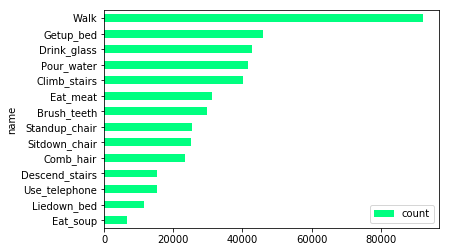

In [12]:
sqlContext.registerDataFrameAsTable(schemacount, "test_table")
df1=sqlContext.sql("Select * from test_table")
pdf1=df1.toPandas()
pdf1.plot(kind='barh',x='name',y='count',colormap='winter_r')

## Performing statistical operations

In [13]:
# using spark SQL
spark.sql('''
    select 
        *,
        max/min as minmaxratio -- compute minmaxratio based on previously computed values
        from (
            select 
                min(ct) as min, -- compute minimum value of all classes
                max(ct) as max, -- compute maximum value of all classes
                mean(ct) as mean, -- compute mean between all classes
                stddev(ct) as stddev -- compute standard deviation between all classes
                from (
                    select
                        count(*) as ct -- count the number of rows per class and rename it to ct
                        from df -- access the temporary query table called df backed by DataFrame df
                        group by class -- aggrecate over class
                )
        )   
''').show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



In [14]:
# using DataFrame API
from pyspark.sql.functions import col, min, max, mean, stddev

df \
    .groupBy('class') \
    .count() \
    .select([ 
        min(col("count")).alias('min'), 
        max(col("count")).alias('max'), 
        mean(col("count")).alias('mean'), 
        stddev(col("count")).alias('stddev') 
    ]) \
    .select([
        col('*'),
        (col("max") / col("min")).alias('minmaxratio')
    ]) \
    .show()

+----+-----+------------------+------------------+-----------------+
| min|  max|              mean|            stddev|      minmaxratio|
+----+-----+------------------+------------------+-----------------+
|6683|92254|31894.928571428572|21284.893716741157|13.80427951518779|
+----+-----+------------------+------------------+-----------------+



## Dealing with Class Imbalance
Let’s rebalance. In the flowing we limit the number of elements per class to the amount of the least represented class. This is called undersampling. Other ways of rebalancing can be found here:

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/



In [15]:
from pyspark.sql.functions import min

# create a lot of distinct classes from the dataset
classes = [row[0] for row in df.select('class').distinct().collect()]

# compute the number of elements of the smallest class in order to limit the number of samples per calss
min = df.groupBy('class').count().select(min('count')).first()[0]

# define the result dataframe variable
df_balanced = None

# iterate over distinct classes
for cls in classes:
    
    # only select examples for the specific class within this iteration
    # shuffle the order of the elements (by setting fraction to 1.0 sample works like shuffle)
    # return only the first n samples
    df_temp = df \
        .filter("class = '"+cls+"'") \
        .sample(False, 1.0) \
        .limit(min)
    
    # on first iteration, assing df_temp to empty df_balanced
    if df_balanced == None:    
        df_balanced = df_temp
    # afterwards, append vertically
    else:
        df_balanced=df_balanced.union(df_temp)

In [16]:
df_balanced.groupBy('class').count().show()

+--------------+-----+
|         class|count|
+--------------+-----+
| Use_telephone| 6683|
| Standup_chair| 6683|
|      Eat_meat| 6683|
|     Getup_bed| 6683|
|   Drink_glass| 6683|
|    Pour_water| 6683|
|     Comb_hair| 6683|
|          Walk| 6683|
|  Climb_stairs| 6683|
| Sitdown_chair| 6683|
|   Liedown_bed| 6683|
|Descend_stairs| 6683|
|   Brush_teeth| 6683|
|      Eat_soup| 6683|
+--------------+-----+

